# Follow virtual linac guide

Follow guide on http://radiotherapyresearchtools.com/doc/api_tutorial.html

* Virtual linac helper files in /Users/robincole/virtualinac specifically file vl_api_helper.py

* after installing boto3 need to set defaults, see https://boto3.readthedocs.io/en/latest/guide/quickstart.html#installation

* Create profile https://console.aws.amazon.com/iam/home#users/robmarkcole

* Config from terminal using 
    
    aws configure 

aws_access_key_id = AKI************

aws_secret_access_key = ZOA*******

region = us-east-1

In [128]:
from __future__ import print_function
import boto3
import requests
import vl_api_helper as vl   # Daren helper files
import plotdose as vlplt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
pwd

'/Users/xxx/virtualinac'

Logon to AWS, start virtualinac instance, edit security group to accept incoming HTTP

In [4]:
ec2=boto3.resource('ec2')

First we can get the instances, then iterate over the data structure to find information about each instance:

In [5]:
instances = ec2.instances.filter(Filters=
    [{'Name': 'instance-state-name', 'Values': ['running'] }])

In [8]:
dns_names = []
for instance in instances:
        print(instance.public_dns_name)
        dns_names.append(instance.public_dns_name)
url = 'http://' + dns_names[0]

ec2-54-152-232-154.compute-1.amazonaws.com


## VirtuaLinac API

Basic check of availability using requests

In [165]:
r = requests.get(url + '/usage') 

for line in r.text.split('\n'):
        if 'Number of jobs' in line:
            print(line)

<p><b>Number of jobs:</b> 0 </p>


In [11]:
params = {
    'filename'     : 'api_test_1',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : 'True',
    'phantom_size_x' : 500,
    'phantom_size_y' : 500,
    'phantom_size_z' : 400,
    'phantom_voxels_x' : 125,
    'phantom_voxels_y' : 125,
    'phantom_voxels_z' : 100,
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -5,
    'incident_particles' : 10000,
    'brem_splitting' : None,
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [12]:
# vl.print_params(params)     # see parameters

In [13]:
r = requests.post(url, params=params)   # Submit calculation

## Calculation runnning

will take a couple of minutes for acvitity to show up on AWS

In [140]:
# vl._wait_for_jobs(url)  # check activity of job, getting an error, just use requests and usage as above

## On calculation completion, get files 

In [27]:
# vl.get_home(url)

In [20]:
resp = requests.get(url + '/phspfiles') # get page with list of output files

In [21]:
Html_file= open("/Users/robincole/Desktop/output.html","w")  # save output to html file and view
Html_file.write(resp.text)
Html_file.close()

<img src="output1.png", width=500>

In [72]:
vl.get_file_index(url, '06e_z.dat')   # get index of a single file

1

In [74]:
# vl.download(url, '06e_x.dat')   # using Daren function, get an error - write() argument must be str, not bytes

In [141]:
def rc_download(url, file):    # my own helper function to download files
    r = requests.get(address + '/vl_files/' + file, stream=True)
    f = open(file, 'wb')     # use 'wb' write binary
    f.write(r.content)
    f.close()

In [142]:
files_ = ['06e_x.dat', '06e_z.dat', 'cylinder.phantom', 'testing.dose', 'testing.output']  # had to edit download, f = open(filename, 'wb') 
for file in files_:

    print(vl.get_file_index(url,file), file)  # print the files
    rc_download(url, file) # download
    

0 06e_x.dat
1 06e_z.dat
0 cylinder.phantom
0 testing.dose
0 testing.output


## Plots of depth dose and profile work OK

06e_z.dat


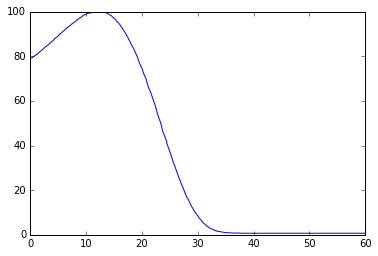

In [123]:
file_to_plot = files_[1]
print(file_to_plot)

plot_array1 = np.loadtxt(file_to_plot)    # load .dat file into array
plt.plot(plot_array1[:,0], plot_array1[:,1])

06e_x.dat


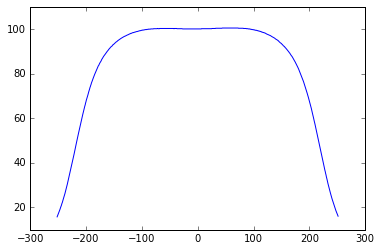

In [124]:
file_to_plot = files_[0]
print(file_to_plot)

plot_array2 = np.loadtxt(file_to_plot)    # load .dat file into array
plt.plot(plot_array2[:,0], plot_array2[:,1])

## How to plot .dose data?

in terminal 

    python plotdose.py testing.dose z  
    
gives an error TypeError: 'float' object cannot be interpreted as an integer


testing.dose
phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 50 yplot: 49 zplot: 39
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


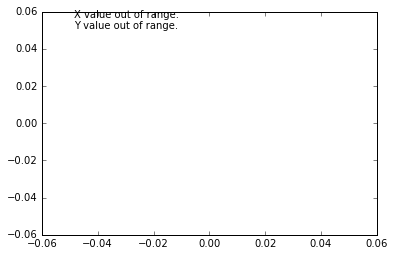

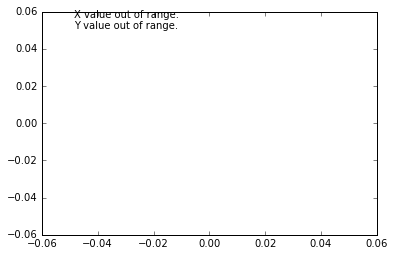

In [152]:
file_to_plot = files_[3]
print(file_to_plot)

vlplt.plotdose(file_to_plot, xplot=50 , yplot=50, zplot=40, plotdir='z')   # what should xplot etc. be, Number of bins?

## Test of uploading my phantom for calculation

I have run create_ct.py on my CT dataset

http://radiotherapyresearchtools.com/doc/output.html#simulate-phantom-and-how-to-build-a-phantom

In [203]:
filename = 'tmp.phantom'
files = {'file': open(filename, 'rb')}
r = requests.post(url + '/upload', files=files)

phantom size [mm]: 353.28 50.0 353.28
Voxels to plot. xplot: 512 yplot: 9 zplot: 511
Number of voxels in phantom.  nx: 512 ny: 10 nz: 512


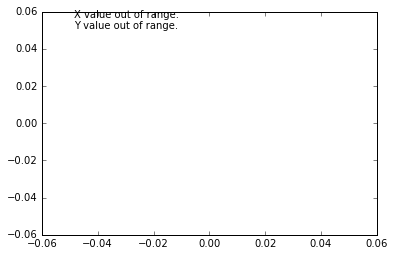

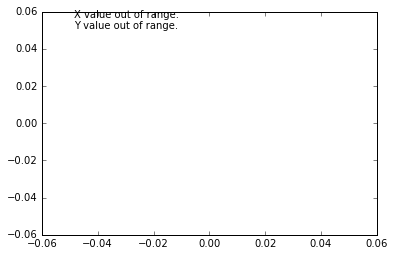

In [213]:
vlplt.plotdose(filename, xplot=512 , yplot=10, zplot=512, plotdir='z')  # Should be able to plot phantom..

In [204]:
print(vl.get_file_index(url,filename), filename)   # check that it has been uploaded OK

1 tmp.phantom


### Qustion : what is phantom_bool?

In [217]:
params = {
    'filename'     : 'api_test_1',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : 'false',
    'phantom_file_name': 'tmp.phantom',
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -5,
    'incident_particles' : 10000,
    'brem_splitting' : None,
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [218]:
r = requests.post(url, params=params)  

In [219]:
r = requests.get(url + '/usage') 

for line in r.text.split('\n'):
        if 'Number of jobs' in line:
            print(line)

<p><b>Number of jobs:</b> 1 </p>


appeares to have worked

In [209]:
resp = requests.get(url + '/phspfiles') # get page with list of output files

In [210]:
Html_file= open("/Users/robincole/Desktop/output.html","w")  # save output to html file and view
Html_file.write(resp.text)
Html_file.close()

Created new .dose file but I cannot plot it

## Generate an online plot of the data

In [175]:
filename = "testing"

In [214]:
doseparams = {}
doseparams['direction'] = 'z'
doseparams['average'] = 15
doseparams['colormap'] = 'True'
extension = '.z2_compare.png'
plot_url = url + '/fig/' + filename + '.dose'

In [215]:
r = requests.get(plot_url, params=doseparams, stream=True)

In [216]:
with open(filename + extension, 'wb') as f:
        for chunk in r.iter_content():
             f.write(chunk)

Plot calculation output

<img src="testing.z2_compare.png", width=600>

## When ready to quit all and exit

In [220]:
instances.terminate()  # to terminate

[{'ResponseMetadata': {'HTTPHeaders': {'content-type': 'text/xml;charset=UTF-8',
    'date': 'Mon, 19 Sep 2016 14:22:56 GMT',
    'server': 'AmazonEC2',
    'transfer-encoding': 'chunked',
    'vary': 'Accept-Encoding'},
   'HTTPStatusCode': 200,
   'RequestId': 'd981e9db-9f78-4a68-b765-b323e24bd016',
   'RetryAttempts': 0},
  'TerminatingInstances': [{'CurrentState': {'Code': 32,
     'Name': 'shutting-down'},
    'InstanceId': 'i-0ee46e19c6dbb12b7',
    'PreviousState': {'Code': 16, 'Name': 'running'}}]}]